# Bennets Hipathia Scriptt

## 1. Instalation & Setup

In [1]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

## Install BiocManager only if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

## Set Bioconductor version COMPATIBLE with R 4.3.x
BiocManager::install(version = "3.18")

## Install edgeR from Bioconductor 3.18
BiocManager::install("edgeR")

# --- Load core libraries ---
library(dplyr)
library(hipathia)
library(data.table)
library(matrixStats)
# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")

## ==========================
## Pakete
## ==========================
library(data.table)    # schnelles IO + Aggregation
library(matrixStats)   # schnelle rowVars / rowSds
# Optional, aber stark empfohlen für große PCA:
use_irlba <- TRUE
if (use_irlba) {
  if (!requireNamespace("irlba", quietly = TRUE)) {
    install.packages("irlba")
  }
  library(irlba)
}



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Old packages: 'igraph', 'xml2'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Old packages: 'igraph', 'xml2'


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


T

[1] ‘3.2.0’

[1] ‘1.1.4’

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




## 2. Parameters

### 2.1 Set Paramter 

In [2]:
# ---- Input files ----
rna_path  <- "RNA_filtered_by_patient7,13,786.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"
expr_pseudobulk_out  <- "expr_pseudobulk_symbols.csv"
design_out           <- "design.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "Normal"        # name in output (left in Hipathia)
group2_name  <- "Tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")Mesothelium
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p4"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
pseudobulk_method <- "sum"
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways





## 3. Patient Filter &Metadata Processing

### 3.1 Load metadata & basic preprocessing


In [3]:
meta <- fread(meta_path, data.table = FALSE)

# Check auf notwendige Spalten
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Patient-ID: pXXXpos / pXXXneg -> pXXX
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Nur relevante Celltypes behalten
meta_filt <- meta[meta[[group_column]] %in% allowed_groups, , drop = FALSE]

### 3.2 Patient filtering based on cell-type abundance


In [4]:
# Zellzahlen pro Patient × Celltype
cell_counts <- with(
  meta_filt,
  table(patient_id, .subset2(meta_filt, group_column))
)

# Summen für group1 / group2
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Patienten, die genug Zellen von BEIDEN Gruppen haben
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))
if (length(valid_patients) == 0) {
  stop("Kein Patient erfüllt min_cells-Kriterium für beide Gruppen.")
}

## Diagnose-Tabelle (falls du sie brauchst)
patients <- rownames(cell_counts)
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

### 3.3 Diagnostic table & final metadata assembly


In [5]:

# Summen für group1 / group2
diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), ] <- as.numeric(group1_counts[patients])
diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), ] <- as.numeric(group2_counts[patients])

# Einzelne Celltypes
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}

diagnosis_matrix["keep", ] <- ifelse(
  group1_counts[patients] >= min_cells & group2_counts[patients] >= min_cells,
  "TRUE", "FALSE"
)

diagnosis_table <- as.data.frame(diagnosis_matrix, stringsAsFactors = FALSE)
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Finales Metadata nur mit validen Patienten
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, , drop = FALSE]

# Normal/Tumor Label
meta_final$group <- ifelse(
  meta_final[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Barcodes, die nach Filter übrig sind
filtered_barcodes <- unique(meta_final$cell_id)
if (length(filtered_barcodes) == 0) {
  stop("Patient filter produced zero remaining cell barcodes.")
}
message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))


                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "Normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "Tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "Normal"     0     0
Mesothelium                0     0
group2_name = "Tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: Normal vs Tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



## 4. RNA Reader & Standardisation

### 4.1 Helper functions

In [6]:
# kleines Trim-Utility
trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]])) {
      df[[i]] <- trimws(df[[i]])
    }
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- trimws(as.character(v))
  non_na <- v[!is.na(v)]
  if (length(non_na) == 0) return(FALSE)

  mean(grepl("[A-Za-z]", non_na)) > 0.5 &&
    mean(nchar(non_na) < 20) > 0.95 &&
    mean(grepl("-", non_na)) < 0.5 &&
    mean(grepl("^\\d+$", non_na)) < 0.1
}



### 4.2. Read RNA File

In [7]:
rna_raw <- fread(rna_path, data.table = FALSE)
rna_raw <- trim_all(rna_raw)

# Gene-Spalte finden
gene_name_hits <- which(tolower(colnames(rna_raw)) %in% c("gene", "genes", "symbol", "geneid"))

if (length(gene_name_hits) == 1) {
  gene_col <- gene_name_hits
} else {
  first_col <- rna_raw[[1]]
  if (looks_gene_symbol(head(first_col, 200))) {
    gene_col <- 1
  } else {
    cand <- which(sapply(rna_raw, function(col) looks_gene_symbol(head(col, 200))))
    gene_col <- cand[1]
  }
}

if (is.na(gene_col) || length(gene_col) == 0) {
  stop("Could not detect gene column.")
}

colnames(rna_raw)[gene_col] <- "Gene"

### 4.4. Standardization RNA Matrix

In [8]:
rna_barcodes   <- setdiff(colnames(rna_raw), "Gene")
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

if (length(keep_barcodes) == 0) {
  stop("No overlapping barcodes between RNA and filtered metadata.")
}

# Nur Gene + benötigte Barcodes
rna <- rna_raw[, c("Gene", keep_barcodes), drop = FALSE]

# Numeric-Konvertierung vektorisiert
rna[, keep_barcodes] <- lapply(rna[, keep_barcodes, drop = FALSE], function(x) {
  x <- trimws(as.character(x))
  x[x == ""] <- NA
  suppressWarnings(as.numeric(x))
})

# Leere Gene droppen
rna$Gene <- trimws(as.character(rna$Gene))
rna <- rna[rna$Gene != "" & !is.na(rna$Gene), , drop = FALSE]

# Duplikate effizient mit data.table collapsen
if (anyDuplicated(rna$Gene)) {
  message("Duplicate genes detected → collapsing by sum (data.table).")
  dt <- as.data.table(rna)
  rna_dt <- dt[, lapply(.SD, sum, na.rm = TRUE), by = Gene]
  setcolorder(rna_dt, c("Gene", keep_barcodes))
  rna <- as.data.frame(rna_dt)
}

# Export
write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 996 barcodes after patient filtering.

Wrote standardized RNA: 996 barcodes kept.



## 5. PCA befor and after Patient filter

### 5.1. PCA utility function (variance filtering)

In [9]:
run_pca <- function(mat, n_pc = 20) {
  # Gene mit Varianz > 0
  vars <- rowVars(mat, useNames = FALSE, na.rm = TRUE)
  mat2 <- mat[vars > 0, , drop = FALSE]

  if (use_irlba) {
    irlba::prcomp_irlba(t(mat2), n = n_pc, center = TRUE, scale. = TRUE)
  } else {
    prcomp(t(mat2), scale. = TRUE)
  }
}


### 5.2. PCA before Patient Filter

### 5.3. PCA after Patient Filter

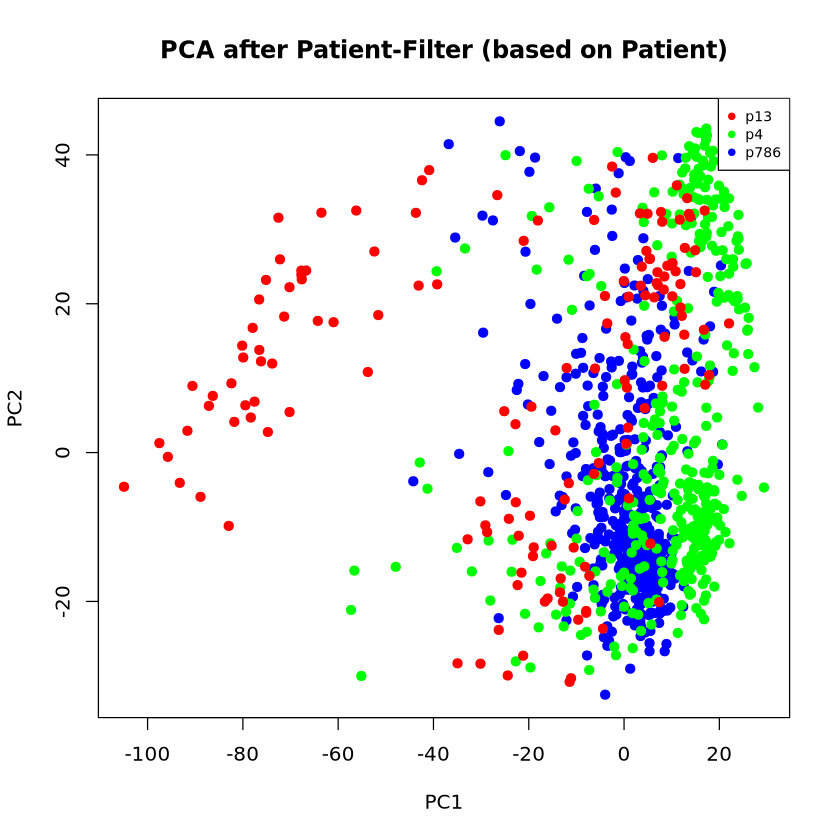

In [10]:

filt_barcodes <- keep_barcodes
pca_filt_mat <- as.matrix(rna[, filt_barcodes, drop = FALSE])
pca_filt <- run_pca(pca_filt_mat, n_pc = 10)

filt_meta <- meta_final[match(filt_barcodes, meta_final$cell_id), ]
patient_filt <- factor(filt_meta$patient_id)
pal_filt <- rainbow(length(levels(patient_filt)))
cols_filt <- pal_filt[patient_filt]

plot(
  pca_filt$x[, 1], pca_filt$x[, 2],
  xlab = "PC1", ylab = "PC2",
  main = "PCA after Patient-Filter (based on Patient)",
  pch = 19, col = cols_filt
)
legend("topright", legend = levels(patient_filt), col = pal_filt, pch = 19, cex = 0.7)


## Check

### 5.1. Check: cells per patient X


In [11]:
## ==========================
## Inspect patient cell composition
## ==========================

cat("\n===== Inspecting patient:", inspect_sample, "=====\n")

# Direkter Filter
meta_inspect <- meta[meta$orig.ident == inspect_sample, , drop = FALSE]

if (nrow(meta_inspect) == 0) {
  stop("No cells found for patient: ", inspect_sample)
}

# Liste der einzigartigen Zelltypen
unique_celltypes_inspect <- unique(meta_inspect[[group_column]])
cat("\nUnique cell types for patient", inspect_sample, ":\n")
print(unique_celltypes_inspect)

# Counts pro Celltype
celltype_counts <- table(meta_inspect[[group_column]])
cat("\nCell counts for patient", inspect_sample, ":\n")
print(celltype_counts)

cat("\n===== End inspection for:", inspect_sample, "=====\n\n")



===== Inspecting patient: p4 =====

Unique cell types for patient p4 :
 [1] "TAMs"          "Malignant"     "Mono_CD16"     "CD8"          
 [5] "cDC2"          "KLRC1_NK"      "CD4"           "Mono_CD14"    
 [9] "B_cells"       "Fibroblasts"   "Mesothelium"   "TFH"          
[13] "FGFBP2_NK"     "pDC"           "Tregs"         "Plasma"       
[17] "cDC1"          "SmoothMuscle"  "NKlike_Tcells" "Mast"         
[21] "Vein"          "mregDC"        "PLVAP"        

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
  

### 5.2. Check: Barcode Overlap AFTER standardization

In [12]:
meta_ids <- unique(meta_final$cell_id)
rna_ids  <- setdiff(colnames(rna), "Gene")

overlap <- intersect(meta_ids, rna_ids)

prop_rna  <- length(overlap) / length(rna_ids)   # Wie viel % der RNA sind in meta?
prop_meta <- length(overlap) / length(meta_ids)  # Wie viel % der meta_final haben RNA?

cat("\n===== BARCODE OVERLAP CHECK =====\n")
cat("RNA barcodes:        ", length(rna_ids), "\n")
cat("Meta barcodes:       ", length(meta_ids), "\n")
cat("Overlap:             ", length(overlap), "\n")
cat(sprintf("Coverage RNA  -> meta:  %.1f%%\n", 100 * prop_rna))
cat(sprintf("Coverage meta -> RNA:   %.1f%%\n", 100 * prop_meta))

# WIRKLICH WICHTIG:
if (prop_rna < 0.99) {
  warning("Nicht alle RNA-Barcodes haben passende Metadata – DAS ist ein echtes Problem.")
} else {
  message("Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔")
}



===== BARCODE OVERLAP CHECK =====
RNA barcodes:         996 
Meta barcodes:        996 
Overlap:              996 
Coverage RNA  -> meta:  100.0%
Coverage meta -> RNA:   100.0%


Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔



In [13]:
# 1. Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# 2. Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes))

# 3. How many barcodes match between RNA and metadata?
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# 4. Which RNA barcodes were NOT kept by the patient filter?
lost <- setdiff(original_rna_barcodes, filtered_barcodes)
message("RNA barcodes discarded by patient filter: ", length(lost))
if (length(lost) > 0) print(head(lost, 20))




Original RNA barcodes: 21085

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 996

RNA barcodes discarded by patient filter: 20089



 [1] "p786pos_AAACCCAAGTTGGAAT-1" "p786pos_AAACCCACAAACACCT-1"
 [3] "p786pos_AAACCCATCCACATAG-1" "p786pos_AAACGAACACATACGT-1"
 [5] "p786pos_AAACGAACAGCTGGTC-1" "p786pos_AAACGAAGTGTGAGCA-1"
 [7] "p786pos_AAACGCTGTATCACGT-1" "p786pos_AAACGCTTCAGGGTAG-1"
 [9] "p786pos_AAAGAACAGTGCAGGT-1" "p786pos_AAAGGATGTCCCTGAG-1"
[11] "p786pos_AAAGGATTCTCTATGT-1" "p786pos_AAAGGATTCTTCCCAG-1"
[13] "p786pos_AAAGGGCCAAGCCCAC-1" "p786pos_AAAGGGCTCCCATACC-1"
[15] "p786pos_AAAGGTAAGCATGCAG-1" "p786pos_AAAGGTACAATGGCAG-1"
[17] "p786pos_AAAGGTACACTCGATA-1" "p786pos_AAAGGTAGTAGTGGCA-1"
[19] "p786pos_AAAGGTAGTGGAATGC-1" "p786pos_AAAGGTATCAGCAATC-1"


## 6. Pseudobulk Aggregation (Patient × Group) 

### 6.1 Barcode Filtering & Group Assignment

In [14]:
message("\n===== BUILDING PSEUDOBULK (Patient × Group) =====")

# 1) Keep filtered barcodes that exist in RNA
barcode_cols <- intersect(colnames(rna), filtered_barcodes)

rna_sub <- rna[, c("Gene", barcode_cols), drop = FALSE]

# 2) Filter metadata to matched barcodes
meta_sub <- meta_final[meta_final$cell_id %in% barcode_cols, ]

# 3) Assign groups (Normal/Tumor)
meta_sub$group <- ifelse(
    meta_sub[[group_column]] %in% group1_types,
    group1_name,
    group2_name
)

# 4) Build Patient×Group sample names
meta_sub$sample_group <- paste0(meta_sub$patient_id, "_", meta_sub$group)

sample_groups <- unique(meta_sub$sample_group)

# 5) Map barcode -> sample_group (very fast)
barcode_to_sg <- meta_sub$sample_group
names(barcode_to_sg) <- meta_sub$cell_id


===== BUILDING PSEUDOBULK (Patient × Group) =====



### 6.2. Pseudobulk Aggregation (sum across all cells)

In [ ]:

# 6) Create matrix (genes × barcodes)
mat <- as.matrix(rna_sub[, barcode_cols, drop = FALSE])

# 7) Unique sample groups
sg_levels <- unique(barcode_to_sg)

# 8) Build matrix: for each sample_group sum columns
pb_mat <- sapply(sg_levels, function(sg) {
    cols <- names(barcode_to_sg)[barcode_to_sg == sg]
    if (length(cols) == 1)
        return(mat[, cols])
    rowSums(mat[, cols, drop = FALSE])
})

# 9) Build final dataframe
expr_pseudobulk <- data.frame(
    Gene = rna_sub$Gene,
    pb_mat,
    check.names = FALSE
)

# 10) Build design matrix
design <- data.frame(
    sample_id = sg_levels,
    patient   = sapply(strsplit(sg_levels, "_"), `[`, 1),
    group     = sapply(strsplit(sg_levels, "_"), `[`, 2)
)

### 6.3. Output Generation & QC Summary

In [ ]:
# 11) Save files
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design, design_out, row.names = FALSE)

message("Pseudobulk written for ", length(sg_levels), " sample groups.")
cat("\n===== Cells per Patient × Group (after all filters) =====\n")
qc_table <- table(meta_sub$patient_id, meta_sub$group)
print(qc_table)

### 6.4. PCA on Pseudobulk

In [ ]:
message("\n===== PCA on Pseudobulk =====")

# 1) Extract matrix (Gene × Samplegroups)
pb_mat <- as.matrix(expr_pseudobulk[, setdiff(colnames(expr_pseudobulk), "Gene"), drop = FALSE])

# 2) Remove genes with zero variance
library(matrixStats)
vars <- rowVars(pb_mat)
pb_mat <- pb_mat[vars > 0, , drop = FALSE]

# 3) PCA (irlba falls vorhanden)
if (requireNamespace("irlba", quietly = TRUE)) {
    pca_res <- irlba::prcomp_irlba(t(pb_mat), n = 5)
} else {
    pca_res <- prcomp(t(pb_mat), scale. = TRUE)
}

# 4) Farben basierend auf Gruppe (Normal/Tumor)
groups <- design$group
cols <- ifelse(groups == group1_name, "#1f77b4", "#d62728")  # blau/rot

# 5) Plot
plot(
    pca_res$x[, 1], pca_res$x[, 2],
    col = cols,
    pch = 19,
    xlab = "PC1",
    ylab = "PC2",
    main = "PCA – Pseudobulk (Patient × Gruppe)"
)
legend(
    "topright",
    legend = unique(groups),
    col = c("#1f77b4", "#d62728"),
    pch = 19
)


## 7. Map Gene Symbols to Entrez IDs


### 7.1 Load Pseudobulk Matrix & Prepare Gene Symbols

In [ ]:
message("\n===== SYMBOL → ENTREZ MAPPING =====")

library(org.Hs.eg.db)
library(data.table)

# expr_pseudobulk ist schon im RAM, nicht erneut laden!
expr_pb <- expr_pseudobulk

# Check gene column
if (!"Gene" %in% colnames(expr_pb)) stop("Column 'Gene' missing in pseudobulk matrix.")

# Extract gene symbols
gene_symbols <- expr_pb$Gene

### 7.2 Map Gene Symbols → Entrez IDs

In [ ]:
# Map SYMBOL → ENTREZ
entrez_ids <- mapIds(
    org.Hs.eg.db,
    keys = gene_symbols,
    column = "ENTREZID",
    keytype = "SYMBOL",
    multiVals = "first"
)

# Add Entrez to the matrix
expr_pb$EntrezID <- entrez_ids

# Remove genes without Entrez ID
expr_pb <- expr_pb[!is.na(expr_pb$EntrezID), ]

# Convert to data.table for fast aggregation
dt <- as.data.table(expr_pb)

# Remove Gene column (Symbol is no longer needed)
dt[, Gene := NULL]

### 7.3. Aggregate Counts per Entrez ID & Save Output

In [ ]:
# Aggregate by EntrezID using SUM (correct for pseudobulk counts)
dt_sum <- dt[, lapply(.SD, sum), by = EntrezID]

# Set EntrezID as rownames
expr_pb_entrez <- as.data.frame(dt_sum)
rownames(expr_pb_entrez) <- expr_pb_entrez$EntrezID
expr_pb_entrez$EntrezID <- NULL

# Save file
write.csv(expr_pb_entrez, "expr_pseudobulk_entrez.csv", row.names = TRUE)

# Report
cat("\n===== MAPPING DONE (optimized) =====\n")
cat("Input genes (symbols): ", length(gene_symbols), "\n", sep = "")
cat("Mapped to Entrez IDs : ", nrow(expr_pb_entrez), "\n", sep = "")
cat("File written: expr_pseudobulk_entrez.csv\n\n")


## 8. TMM Normalization

In [ ]:
## ===========================================
## TMM normalisation on pseudobulk (Entrez)
## ===========================================

message("\n===== TMM NORMALIZATION =====")

library(edgeR)

# Load Entrez-count matrix
expr_counts <- expr_pb_entrez  # Gene × Sample

# Check numeric
stopifnot(all(sapply(expr_counts, is.numeric)))

# Create DGEList
dge <- DGEList(counts = expr_counts)

# Calculate TMM factors
dge <- calcNormFactors(dge, method = "TMM")

message("Norm factors:")
print(dge$samples$norm.factors)

# Compute logCPM
logCPM <- cpm(dge, log = TRUE, prior.count = 1)

# Save logCPM matrix
write.csv(logCPM, "expr_pseudobulk_TMM_logCPM.csv")

message("\n===== TMM DONE =====")
message("Samples: ", ncol(logCPM))
message("Genes:   ", nrow(logCPM))
message("File written: expr_pseudobulk_TMM_logCPM.csv\n")


In [ ]:
## ===========================================
## PCA using TMM-normalized logCPM
## ===========================================

message("\n===== PCA on TMM logCPM =====")

# Matrix format: samples × genes
pca_mat <- t(logCPM)

# Remove zero variance genes
vars <- apply(logCPM, 1, var)
pca_mat <- t(logCPM[vars > 0, ])

# PCA (fast if irlba installed)
if (requireNamespace("irlba", quietly = TRUE)) {
    pca_res <- irlba::prcomp_irlba(pca_mat, n = 5)
} else {
    pca_res <- prcomp(pca_mat, scale. = TRUE)
}

# Colors by design group
groups <- design$group
cols <- ifelse(groups == group1_name, "#1f77b4", "#d62728")

# Plot
plot(
    pca_res$x[,1], pca_res$x[,2],
    col = cols, pch = 19,
    xlab = "PC1", ylab = "PC2",
    main = "PCA – TMM normalized pseudobulk"
)

legend(
    "topright",
    legend = unique(groups),
    col = c("#1f77b4", "#d62728"),
    pch = 19
)
  

## 9. Preprocessment & Hipathia Normalization

### 9.1. Gene IDs translation

In [ ]:
#3.1
library(hipathia)

trans_data <- as.matrix(read.csv("expr_pseudobulk_entrez.csv",
                                 row.names = 1, check.names = FALSE))



### 9.2. Data scaling & normalization

In [ ]:
#3.2
# exakt der Vignetten-Schritt:
exp_data <- normalize_data(trans_data, by_quantiles = FALSE)

write.csv(data.frame(Gene=rownames(exp_data), exp_data, check.names=FALSE),
          "Vinette_Like_RNA-Data.csv", row.names=FALSE)


In [ ]:
## 3.2-B: Boxplot vor Normalisierung

boxplot(
  log2(trans_data + 1),
  main = "Before Hipathia Normalization",
  outline = FALSE
)


In [ ]:
## 3.2-C: Hipathia normalization with fallback

# Threads begrenzen
Sys.setenv(
  OMP_NUM_THREADS = "1",
  MKL_NUM_THREADS = "1",
  OPENBLAS_NUM_THREADS = "1",
  VECLIB_MAXIMUM_THREADS = "1"
)

# Quantile-Normierung versuchen
exp_data <- tryCatch(
  normalize_data(trans_data, by_quantiles = TRUE),
  error = function(e) {
    message("Quantile normalization failed: ", e$message)
    normalize_data(
      trans_data,
      by_quantiles = FALSE,
      truncation_percentil = 0.95
    )
  }
)

# Boxplot nach Normalisierung
boxplot(
  exp_data,
  main = "After Hipathia Normalization",
  outline = FALSE
)

message("3.2-C: Hipathia normalization finished.")


## 10. Pathaway activation computation

### 10.1. Download Pathaways

In [ ]:
## ===========================
## 4.1 Load Hipathia Pathways
## ===========================

if (length(pathways_list) == 0) {
    message("Loading ALL pathways for species: ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading selected pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# --- Basic diagnostics ---
message("Number of pathways loaded: ", length(pathways))

# Show first 5 pathway names (if available)
if (length(pathways) >= 5) {
    print(names(pathways)[1:5])
} else {
    print(names(pathways))
}

# Show first 10 identifiers from Hipathia list
pw_list <- get_pathways_list(pathways)
print(head(pw_list, 10))


### 10. 2. Compute the signal

In [ ]:
#4.3 Using Hipathia to comute the signal
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

In [ ]:
# Gene IDs in deiner Expression Matrix
input_genes <- rownames(exp_data)

# Alle Gene, die Hipathia benötigt
hipathia_genes <- unique(unlist(lapply(pathways$pathigraphs, function(p) p$genes)))

# Gene, die Hipathia braucht, aber du nicht hast
missing_genes <- setdiff(hipathia_genes, input_genes)

length(missing_genes)
head(missing_genes, 50)
# So niedriger des do besser
                                    

In [ ]:
#4.3 Using Hipathia to comute the signal
results

In [ ]:
#4.3 Using Hipathia to comute the signal
path_vals <- get_paths_data(results)
hhead(path_vals, 4)

## 11. Functional Annotation: UniProt & GO Term Activation

In [ ]:
#5 Function activation computation
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")
#142/1654 soll so sein

## 12. Pathway/Function activation analysis

### 11.1 Sample design extraction from pathway matrix

In [ ]:
sample_ids <- colnames(path_vals)

design <- data.frame(
    sample  = sample_ids,
    patient = sub("_(.*)$", "", sample_ids),
    group   = sub("^.*_", "", sample_ids),
    row.names = sample_ids,
    stringsAsFactors = FALSE
)

sample_group <- design$group
names(sample_group) <- design$sample


### 11.2 Extract numeric matrix from path_vals (Hipathia-compatible)

In [ ]:
if (inherits(path_vals, "SummarizedExperiment")) {
    pm <- assay(path_vals)

} else if (is.list(path_vals) && !is.null(path_vals[[1]]) &&
           (is.matrix(path_vals[[1]]) || inherits(path_vals[[1]], "DelayedMatrix"))) {
    pm <- as.matrix(path_vals[[1]])

} else if (is.matrix(path_vals)) {
    pm <- path_vals

} else {
    stop("ERROR: path_vals hat einen unbekannten Datentyp und kann nicht in eine Matrix umgewandelt werden.")
}

# Sicherheitscheck
if (!is.matrix(pm)) stop("pm ist keine Matrix.")

### 11.3. Extract pathway IDs from subpathway IDs

In [ ]:
sub_to_path <- vapply(
    strsplit(rownames(pm), "-"),
    function(x) x[2],
    FUN.VALUE = character(1)
)

### 11.4.  Aggregate subpathway activations → pathway-level matrix

In [ ]:
message("Aggregiere Subpathways zu Pathways...")

pathlevel_vals <- rowsum(pm, group = sub_to_path)


### 11.4. Paired Wilcoxon test per pathway

In [ ]:
zero_diff <- character(0)
unpaired  <- character(0)

pvals <- suppressWarnings(sapply(rownames(pathlevel_vals), function(p) {

    vals <- pathlevel_vals[p, ]

    g1 <- vals[design$group == group1_name]
    g2 <- vals[design$group == group2_name]

    # gleiche Anzahl Samples für Pairing?
    if (length(g1) != length(g2)) {
        unpaired <<- c(unpaired, p)
        return(NA_real_)
    }

    # keine Unterschiede?
    if (all(g1 - g2 == 0)) {
        zero_diff <<- c(zero_diff, p)
        return(NA_real_)
    }

    # paired Wilcoxon
    tryCatch(
        wilcox.test(g1, g2, paired = TRUE)$p.value,
        error = function(e) NA_real_
    )
}))

### 11.5. Summary and Results

In [ ]:

comp <- data.frame(
    pathway = rownames(pathlevel_vals),
    p_value = pvals,
    stringsAsFactors = FALSE
)

cat("\n===== Wilcoxon paired summary =====\n")
cat("Vergleich:", group1_name, "vs", group2_name, "\n")
cat("Total pathways:", nrow(comp), "\n")
cat("Out-of-pair:", length(unpaired), "\n")
cat("Zero-diff:", length(zero_diff), "\n")

if (length(zero_diff) > 0) {
    cat("Beispiele Zero-diff:\n")
    print(head(zero_diff, 5))
}

if (length(unpaired) > 0) {
    cat("Beispiele unpaired:\n")
    print(head(unpaired, 5))
}

# Ausgabe
head(comp)


## 13. Significant Test

### 12.1. RAW Significance Check (before FDR)

In [ ]:
alpha_strict <- 0.05
alpha_loose  <- 0.10

# Nur Zeilen mit gültigen p-Werten berücksichtigen
valid_idx <- !is.na(comp$p_value)

comp$significant_raw_strict <- FALSE
comp$significant_raw_loose  <- FALSE

comp$significant_raw_strict[valid_idx] <- comp$p_value[valid_idx] < alpha_strict
comp$significant_raw_loose[valid_idx]  <- comp$p_value[valid_idx] < alpha_loose

sig_strict <- comp$pathway[comp$significant_raw_strict]
sig_loose  <- comp$pathway[comp$significant_raw_loose]

cat("\n===== RAW SIGNIFICANCE (before FDR) =====\n")
cat("Strict significant (p < 0.05): ", length(sig_strict), "\n")
if (length(sig_strict) > 0) print(sig_strict)

cat("\nLoose significant (p < 0.10): ", length(sig_loose), "\n")
if (length(sig_loose) > 0) print(sig_loose)

cat("\nTop pathways by raw p-value:\n")
print(head(comp[order(comp$p_value), ], 10))


### 12.2. FDR Correction (Benjamini–Hochberg)

In [ ]:
valid_idx <- !is.na(comp$p_value)

comp$FDR <- NA_real_
comp$FDR[valid_idx] <- p.adjust(comp$p_value[valid_idx], method = "BH")

cat("\n===== FDR Correction Done =====\n")
cat("Anzahl Pfade mit gültigem p-value:", sum(valid_idx), "\n")
cat("Min raw p-value: ", min(comp$p_value[valid_idx]), "\n")
cat("Min FDR value:  ", min(comp$FDR[valid_idx]), "\n")

# Top 10 nach FDR
cat("\nTop pathways by FDR:\n")
print(head(comp[order(comp$FDR), ], 10))


## 14. Mapping pathway p-values onto subpathways

In [ ]:
# =======================================================
# Mapping der Wilcoxon Pathway-p-values zurück
# auf Hipathia Subpathways
# =======================================================

message("\n===== Mapping pathway p-values zurück auf Subpathways =====")

# 1) Alle Subpathway-Namen holen
subpaths <- rownames(path_vals)

# 2) Pathway-ID aus Subpathway extrahieren
#    "P-hsa03320-37" -> "hsa03320"
subpath_path_id <- sapply(strsplit(subpaths, "-"), `[`, 2)

# 3) comp$pathway enthält die hsaXXXX Pathway-Namen aus deinem Wilcoxon
#    -> matchen p-Werte pro Subpath
mapped_pvals <- comp$p_value[ match(subpath_path_id, comp$pathway) ]

# 4) Neues comp im Hipathia-Format erzeugen
comp_expanded <- data.frame(
    pathway = subpath_path_id,
    p_value = mapped_pvals,
    row.names = subpaths,
    stringsAsFactors = FALSE
)

# 5) Ausgabe
message("Subpaths insgesamt: ", length(subpaths))
message("Unique pathways: ", length(unique(subpath_path_id)))
message("Nicht gematcht (NA): ", sum(is.na(mapped_pvals)))

# 6) comp ersetzen
comp <- comp_expanded

head(comp)




In [ ]:
unique(subpath_path_id[is.na(mapped_pvals)])

#"hsa04150" "hsa04912" "hsa04917"

table(subpath_path_id[is.na(mapped_pvals)])


In [ ]:
#6.1  Two classes comparison
pathways_summary <- get_pathways_summary(comp, pathways)
head(pathways_summary, 4)

## 15. Delta PCA

### 15.1. Delta pathway activity (Tumor – Normal) and PCA

In [ ]:
message("\n===== Delta Pathway Activity Calculation =====")

# Pathway-level activation matrix
pm <- assay(path_vals)          # pathways × samples
samples <- colnames(pm)

# Extract patient + group assignment
patients <- design$patient
groups   <- design$group

# Identify paired patients (Normal + Tumor available)
paired_patients <- intersect(
    design$patient[design$group == group1_name],
    design$patient[design$group == group2_name]
)

if (length(paired_patients) == 0) {
    stop("No paired patients found for Delta calculation.")
}

# Prepare Delta matrix
delta_mat <- matrix(
    NA,
    nrow = nrow(pm),
    ncol = length(paired_patients),
    dimnames = list(rownames(pm), paired_patients)
)

# Compute Tumor - Normal per patient (paired)
for (p in paired_patients) {

    # sample IDs
    s_normal <- design$sample[design$patient == p & design$group == group1_name]
    s_tumor  <- design$sample[design$patient == p & design$group == group2_name]

    # compute delta
    delta_mat[, p] <- pm[, s_tumor] - pm[, s_normal]
}

message("Delta matrix: ", nrow(delta_mat), " pathways × ", ncol(delta_mat), " patients")

In [ ]:
apply(delta_mat, 2, function(x) var(x, na.rm = TRUE))[1:10]


### 15.2. Delta Pathway Activity PCA

In [ ]:

message("\n===== Delta Pathway Activity PCA =====")

# --- 0. Remove zero-variance columns ----------------------------------------

zero_var_cols <- which(apply(delta_mat, 2, function(x) var(x, na.rm=TRUE) == 0))

if (length(zero_var_cols) > 0) {
    message("Removing ", length(zero_var_cols),
            " patient(s) with zero variance:")
    print(colnames(delta_mat)[zero_var_cols])
    
    delta_mat_pca <- delta_mat[, -zero_var_cols, drop = FALSE]
} else {
    delta_mat_pca <- delta_mat
}

# Must have at least 2 patients remaining
if (ncol(delta_mat_pca) < 2) {
    stop("Not enough patients with non-zero delta variance for PCA.")
}

# --- 1. Try PCA with scaling ------------------------------------------------

message("Trying PCA with scaling (scale=TRUE)...")

pca_res <- NULL

try({
    pca_res <- prcomp(t(delta_mat_pca), scale. = TRUE)
})

if (!is.null(pca_res)) {
    message("PCA with scale=TRUE succeeded.")
    
} else {

    # --- 2. If scaling PCA fails → use no scaling ---------------------------

    message("PCA with scale=TRUE failed — retrying WITHOUT scaling (scale=FALSE)...")

    try({
        pca_res <- prcomp(t(delta_mat_pca), scale. = FALSE)
    })

    if (!is.null(pca_res)) {
        message("PCA with scale=FALSE succeeded.")
    } else {
        stop("PCA failed: both scaling and no-scaling PCA could not be computed.")
    }
}

# --- 3. Output --------------------------------------------------------------

print(summary(pca_res))

plot(
    pca_res$x[,1], pca_res$x[,2],
    xlab = "PC1", ylab = "PC2",
    main = "PCA – Delta Pathway Activity",
    pch = 19
)

text(
    pca_res$x[,1], pca_res$x[,2],
    labels = colnames(delta_mat_pca),
    pos = 3
)


### 15.3 Ranking of pathways by Delta effect size

In [ ]:
message("\n===== Ranking pathways by Delta effect size =====")

# delta_mat: pathways × patients
# compute mean delta across patients
mean_delta <- rowMeans(delta_mat, na.rm = TRUE)

# compute absolute effect strength
abs_delta <- abs(mean_delta)

# combine into table
delta_rank <- data.frame(
    pathway     = rownames(delta_mat),
    mean_delta  = mean_delta,
    abs_delta   = abs_delta,
    stringsAsFactors = FALSE
)

# sort by absolute delta (descending)
delta_rank <- delta_rank[order(delta_rank$abs_delta, decreasing = TRUE), ]

# show top 10
head(delta_rank, 10)


## 16. Heatmap

In [ ]:
# ================================
# 7) HEATMAPS (Subpaths, Uniprot, GO)
# ================================

library(hipathia)

# Sample grouping (Normal / Tumor)
sample_group <- design$group
names(sample_group) <- design$sample

# 7.1 Subpathway Activation Heatmap
heatmap_plot(
    path_vals,
    group = sample_group,
    colors = "hipathia",
    variable_clust = TRUE
)

# 7.2 Uniprot Function Heatmap
heatmap_plot(
    uniprot_vals,
    group = sample_group,
    colors = "hipathia",
    variable_clust = TRUE
)

# 7.3 GO Function Heatmap
heatmap_plot(
    go_vals,
    group = sample_group,
    colors = "redgreen",
    variable_clust = TRUE
)


### 12. alte Heatmap

## 17. PCA

In [ ]:
# ============================================
# CHECK: PCA feasibility based on significance
# ============================================

# how many informative pathways exist?
n_strict <- sum(comp$p_value < 0.05, na.rm = TRUE)
n_loose  <- sum(comp$p_value < 0.10, na.rm = TRUE)
min_p    <- min(comp$p_value, na.rm = TRUE)

# if absolutely nothing is significant, PCA is misleading
if (is.infinite(min_p) || is.na(min_p)) {
    stop("No valid p-values available. PCA cannot be meaningfully computed.")
}

if (n_strict == 0 && n_loose == 0) {
    stop(paste0(
        "PCA aborted: There is no statistical signal.\n",
        "All pathway p-values are >= 0.10 and the minimum p-value is ", min_p, ".\n",
        "Under these conditions a PCA would not reflect biological structure ",
        "but only noise."
    ))
}

# If only 1 or 2 pathways show weak evidence → warn user
if (n_loose > 0 && n_strict == 0) {
    warning(paste0(
        "Only weak evidence for differences detected (p < 0.10: ", n_loose, 
        "). PCA will likely show no separation."
    ))
}



In [ ]:
pca_plot(pca_model, sample_group, legend = TRUE)

In [ ]:
pca_plot(pca_model, sample_group, legend = TRUE)

In [ ]:

pca_plot(pca_model, group = rep(1:5, 8), main = "Random types",
legend = TRUE)

In [ ]:
multiple_pca_plot(pca_model, sample_group, cex=3, plot_variance = TRUE)

## 18. Pathway_comparison

In [ ]:
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320")

In [ ]:
colors_de <- node_color_per_de(results, pathways, sample_group, "Tumor",
"Normal")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de)

In [ ]:
colors_de_hipathia <- node_color_per_de(results, pathways, sample_group,
"Tumor", "Normal", colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de_hipathia, colors = "hipathia")
pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = colors_de_hipathia,
  colors = "hipathia",
)

In [ ]:
#7.4. Vizualization through a local server
report <- create_report(comp, pathways, "save_noColors")
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...
#report_colors <- create_report(comp, pathways, "save_colors",
#node_colors = colors_de)
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...


In [ ]:

visualize_report(report, port = 4002)

In [ ]:
# 1) alte servr-Prozesse beenden
if (requireNamespace("servr", quietly = TRUE)) {
  dl <- try(servr::daemon_list(), silent = TRUE)
  if (!inherits(dl, "try-error") && NROW(dl)) {
    for (i in dl$id) try(servr::daemon_stop(i), silent = TRUE)
  }
}

# 2) freien Port wählen
port <- servr::random_port()  # nimmt garantiert freien Port, z.B. 4010

# 3) Report visualisieren
visualize_report(report, port = port)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
comp$FDRp.value <- runif(nrow(comp), 0, 0.01)  # zufällige kleine Werte
comp$UP.DOWN <- sample(c("UP","DOWN"), nrow(comp), replace = TRUE)

pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = node_color_per_de(results, pathways, sample_group,
                                  "Tumor", "Normal", colors = "hipathia"),
  colors = "hipathia"
)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
table(design$group)


In [ ]:
table(meta$group, meta$orig.ident)


# Rest